# Advance Lane Finding project


### **Importing the requirements  the project**

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

%matplotlib inline

### **Computing the camera caliberation matric with given images**

In [104]:
def caliberate_camera(images):
    #prepating a object points
    objp = np.zeros(((9*6),3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #arrays to store obj and image points for all images
    objpoints = []
    imgpoints = []
    
    chessboard = [] #For the visualization purpose
    
    #looping over the images in list images
    for image in images:
        img = cv2.imread(image) #reading the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray,(9,6))
        
        if ret == True:  
            objpoints.append(objp)    #If found saving the points to lists
            imgpoints.append(corners)
            
            img = cv2.drawChessboardCorners(gray, (7,6), corners,ret)
            
    if len(imgpoints) > 0:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
    return ret, mtx, dist, rvecs, tvecs

images = glob.glob("camera_cal/*.jpg")

ret, mtx, dist, rvecs, tvecs = caliberate_camera(images)


## Distortion correction function

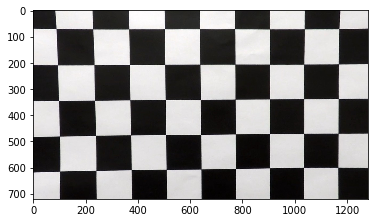

In [105]:
def correct_distortion(img, ret, mtx, dist, rvecs, tvecs ):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = mpimg.imread("camera_cal/calibration1.jpg")
undistorted = correct_distortion(img, ret, mtx, dist, rvecs, tvecs )
plt.imshow(undistorted)

## Defining function to visualize two images

In [106]:
def visualize(img1,img2,comment1='Image',comment2='Final',cm='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
    f.tight_layout()
    ax1.imshow(img1,cmap=cm)
    ax1.set_title(comment1, fontsize=30)
    ax2.imshow(img2,cmap=cm)
    ax2.set_title(comment2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

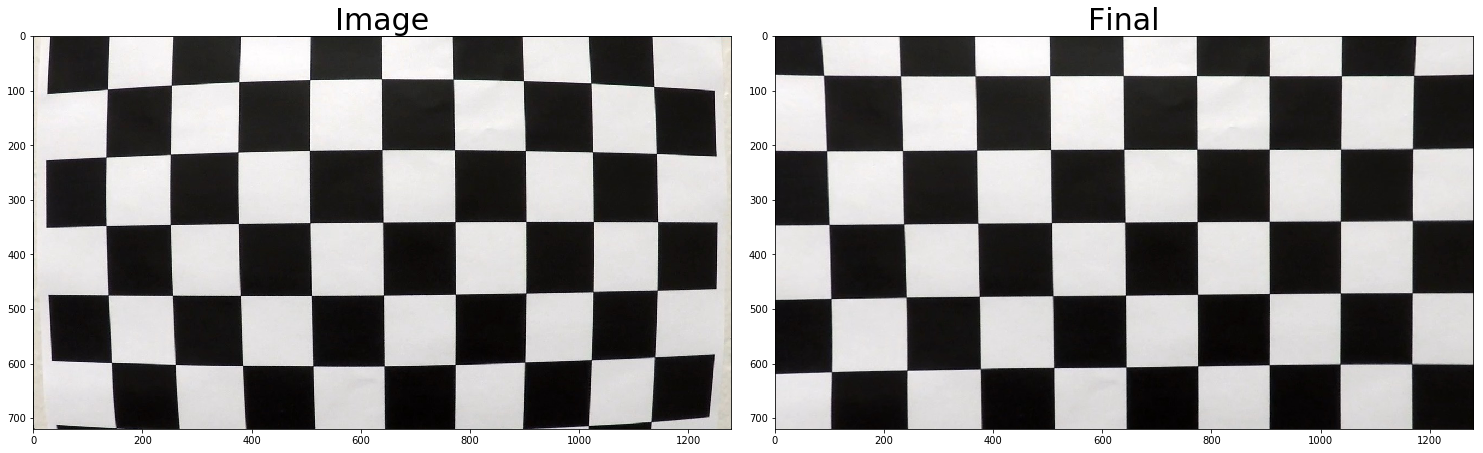

In [107]:
visualize(img,undistorted)

# From the lesson **Gradients and Color spaces**
## calculating the thresholds
We shall calculate all the thresholds to obtain a combined image to detect lane lines over it

### calculating the Sobel in x or y directions 
Using the function I solved in the quiz

In [108]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=5 ,thresh_min=30, thresh_max=100,):
    
    """
    Funtion accepts an RGB image and calculates the sobel in the direction specified in orient variable
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    absolute = np.abs(sobel)
    
    binary_output = np.uint8(255*absolute/np.max(absolute))    
        
    sbinary = np.zeros_like(sobel) 
    
    sbinary[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    
    return sbinary

### Sobel in x direction

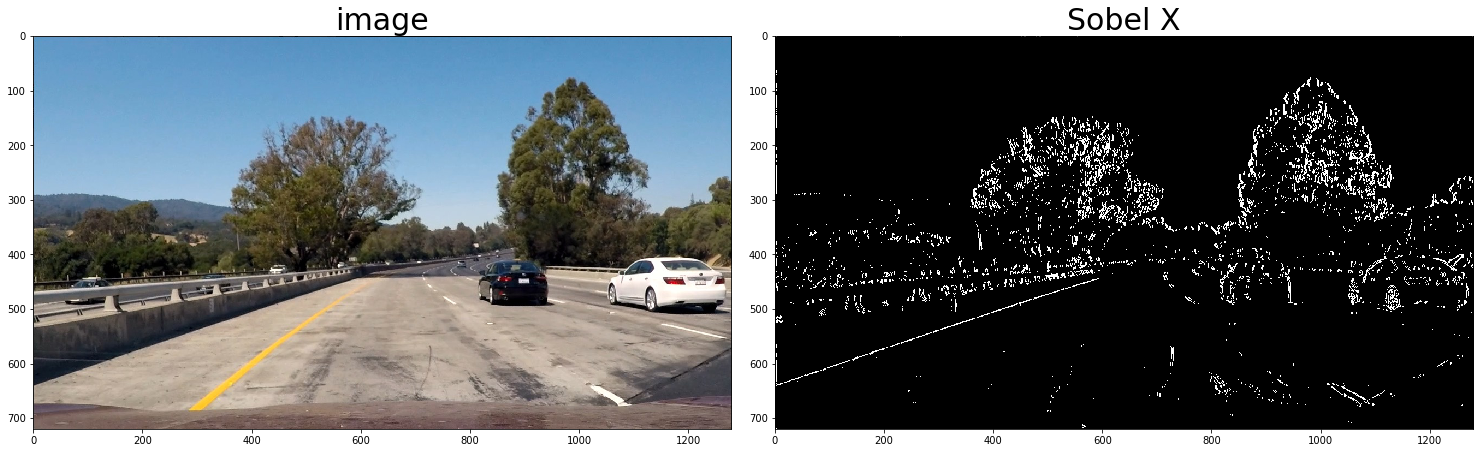

In [131]:
img = mpimg.imread("test_images/test1.jpg")
sobel_x = abs_sobel_thresh(img,orient='x')
visualize(img,sobel_x,comment1='image',comment2='Sobel X')

### Sobel in Y direction

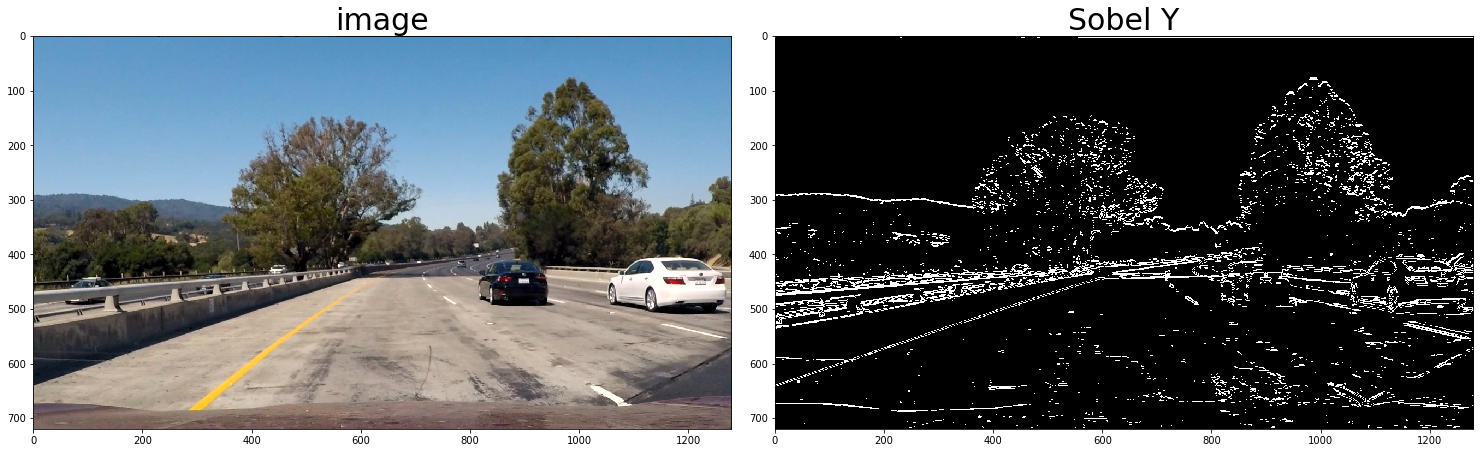

In [130]:
sobel_y = abs_sobel_thresh(img,orient='y')
visualize(img,sobel_y,comment1='image',comment2='Sobel Y')

## Calculating the Magnitude Threshold
Using the Function I solved in the quiz

In [111]:
def mag_thresh(img, sobel_kernel=5, mag_thresh=(30, 255)):
    """
    Accepts an RGB image as input and returns an image with magni
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    magnitude = ((sobelx**2)+(sobely**2))**0.5
    
    absolute = np.abs(magnitude)
    
    binary_output = np.uint8(255*absolute/np.max(absolute))

    sbinary = np.zeros_like(sobelx) 
    
    sbinary[(binary_output >= mag_thresh[0]) & (binary_output <=  mag_thresh[1])] = 1
    
    return sbinary

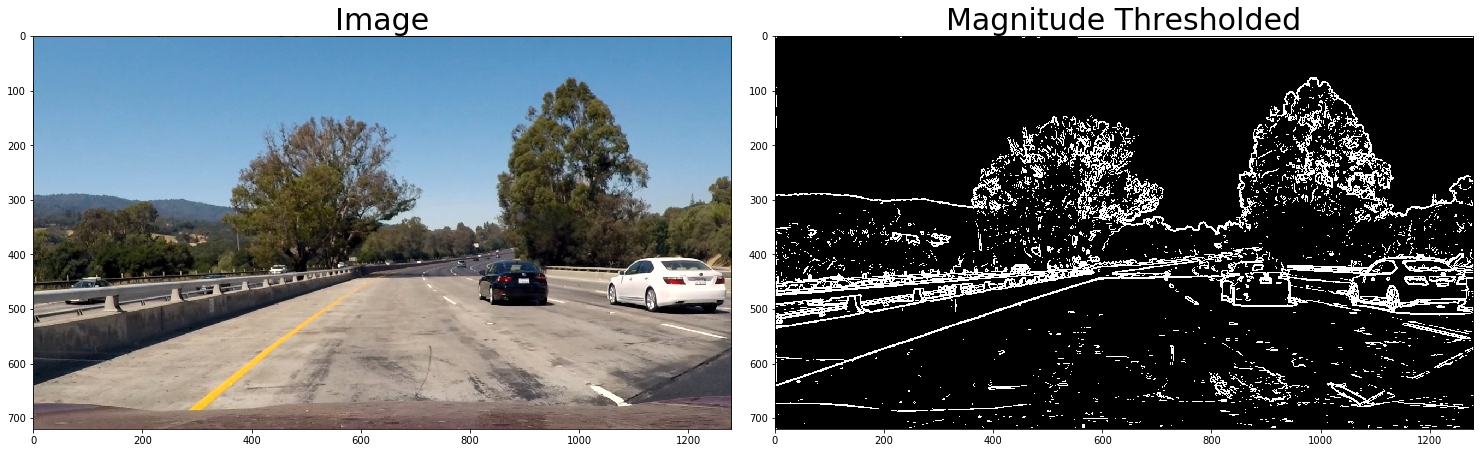

In [112]:
mag_img = mag_thresh(img)
visualize(img, mag_img,comment2='Magnitude Thresholded')

## Directional Gradient
Using the function from the quiz I solved

In [121]:
def dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi/2)):
    
    """
    Accepts an RGB image and returns an direction threshold computed image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # magnitude = ((sobelx**2)+(sobely**2))**0.5
    
    direction = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    binary_output = np.zeros_like(direction) 
    
    binary_output[(direction >= thresh[0]) & (direction <=  thresh[1])] = 1
    
    return binary_output

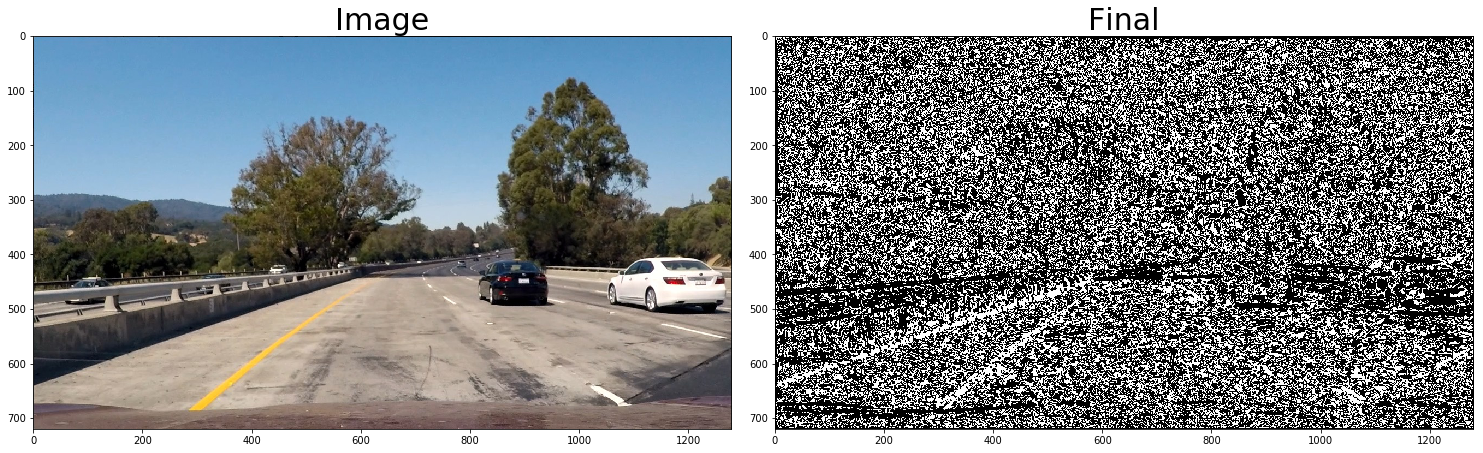

In [129]:
dir_img = dir_threshold(img,sobel_kernel=11)
visualize(img,dir_img)

## Color Thesholding the image
Using the S channel as we have already tested that s channel gives best performance in all the cases

In [133]:
def color_threshold(img, channel='s' ,thresh=(170, 255)):
    """
    Accepts an RGB image and converts it to HLS image and returns a selcted channel-thresholded image
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel == 's':
        layer = hls[:,:,2] 
    elif channel == 'h':
        layer = hls[:,:,0]
    elif channel == 'l':
        layer = hls[:,:,1]
    
    binary_output = np.zeros_like(layer)
    binary_output[(layer >= thresh[0]) & (layer <= thresh[1])] = 1

    # Return the binary image
    return binary_output

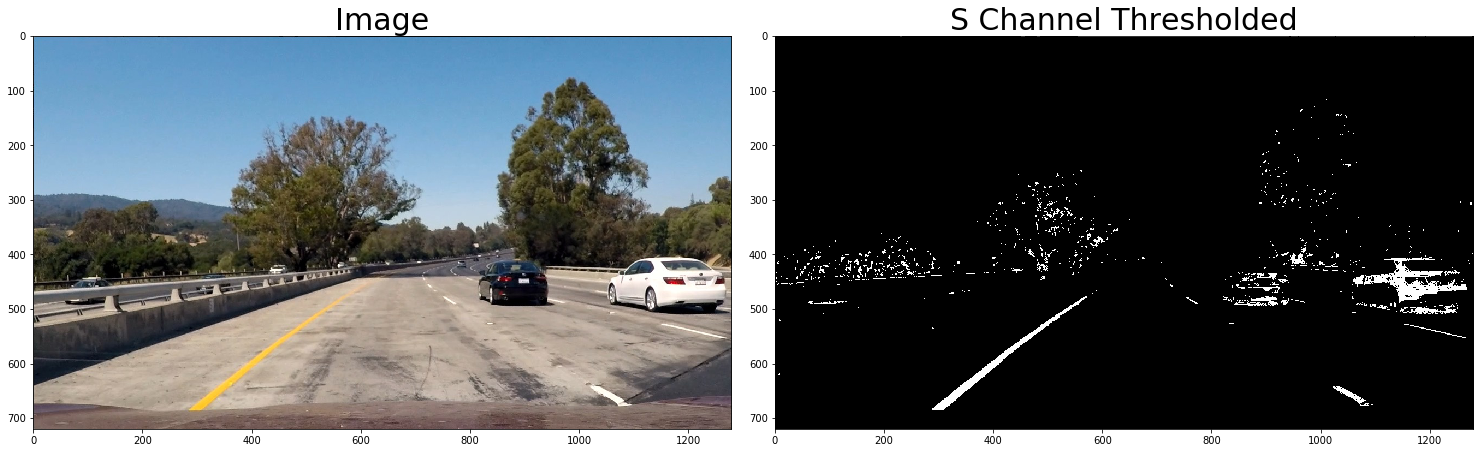

In [135]:
s_channel = color_threshold(img,channel='s')
visualize(img,s_channel,comment2='S Channel Thresholded')

## Combining all the above thresholds to use in lane identification

In [136]:
def Final_threshold(sobel_x, sobel_y, mag_thresh, dir_img, s_channel):
    combined = np.zeros_like(sobel_x)
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag_thresh == 1) & (dir_img == 1)) | (s_channel == 1)] = 1
    return combined

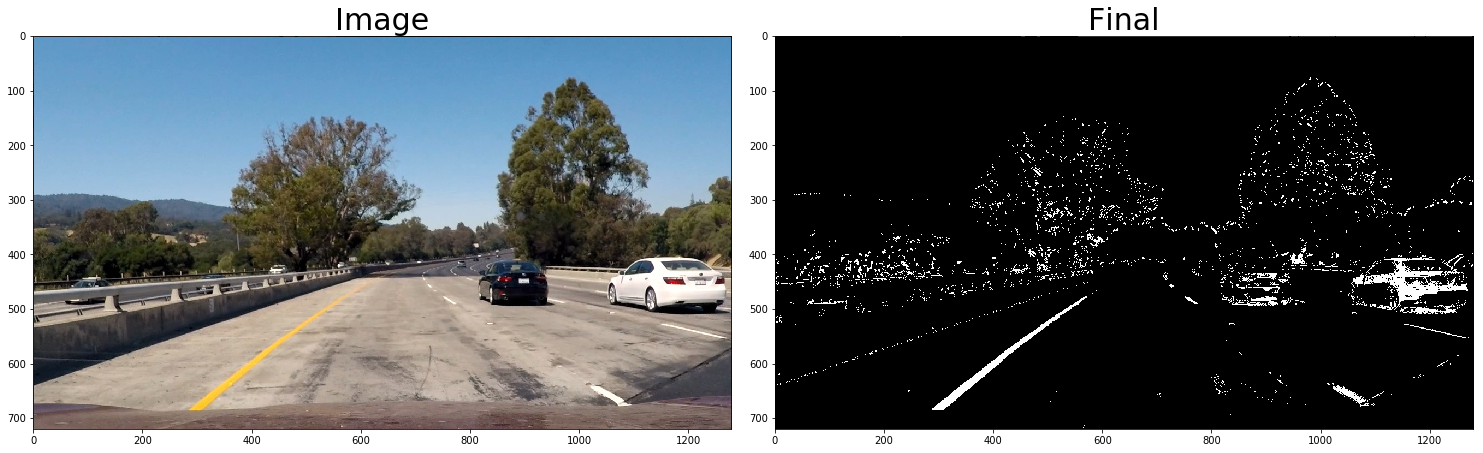

In [137]:
Thresholdedimage = Final_threshold(sobel_x, sobel_y, mag_thresh, dir_img, s_channel)
visualize(img,Thresholdedimage)